## Importing libs and loading the dataset

In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [198]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [199]:
dataset_csv_path = "Metro_Interstate_Traffic_Volume.csv" # 8 attributes of 48,204 examples (plus the target column)

# loading the dataset with pandas (instead of numpy or csv) since there are different datatypes
dataset_csv = pd.read_csv(dataset_csv_path, delimiter=',')
dataset_csv.shape

(48204, 9)

## Dataset attributes
- 1: **holiday**: US National holidays plus regional holiday, Minnesota State Fair
- 2: **temp**: average temp in kelvin
- 3: **rain 1h**: amount in mm of rain that occurred in the hour
- 4: **snow 1h**: amount in mm of snow that occurred in the hour
- 5: **clouds all**: percentage of cloud cover
- 6: **weather main**: short textual description of the current weather
- 7: **weather description**: longer textual description of the current weather
- 8: **date time**: hour of the data collected in local CST time
- target: **traffic volume**: traffic volume

In [200]:
dataset_csv.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

## 0. Visualize the data

In [201]:
dataset_csv.agg(["min", "max", "median", "mean", "std"])

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
min,Christmas Day,0.000000,0.000000,0.000000,0.000000,Clear,SQUALLS,2012-10-02 09:00:00,0.000000
max,Washingtons Birthday,310.070000,9831.300000,0.510000,100.000000,Thunderstorm,very heavy rain,2018-09-30 23:00:00,7280.000000
median,NaN,282.450000,0.000000,0.000000,64.000000,NaN,NaN,NaN,3380.000000
mean,NaN,281.205870,0.334264,0.000222,49.362231,NaN,NaN,NaN,3259.818355
std,NaN,13.338232,44.789133,0.008168,39.015750,NaN,NaN,NaN,1986.860670


In [202]:
mean_values = dataset_csv.groupby("weather_main")[["temp", "traffic_volume"]].mean()
mean_values["temp_celsius"] = mean_values["temp"].apply(lambda temp_K: temp_K - 273.15)
mean_values["size"] = dataset_csv.groupby("weather_main").size() # amount of entries in each group

# order by the weather conditions which have the largest mean traffic volume
mean_values[["size", "temp_celsius", "temp", "traffic_volume"]].sort_values(by="traffic_volume", ascending=False)

,size,temp_celsius,temp,traffic_volume
weather_main,,,,
Clouds,15164,8.316101,281.466101,3618.449749
Haze,1360,2.668581,275.818581,3502.101471
Rain,5672,13.829586,286.979586,3317.905501
Drizzle,1821,10.645431,283.795431,3290.727073
Smoke,20,17.777500,290.927500,3237.650000
Clear,13391,8.339971,281.489971,3055.908819
Snow,2876,-5.194812,267.955188,3016.844228
Thunderstorm,1034,19.566431,292.716431,3001.620890
Mist,5950,6.326892,279.476892,2932.956639


In [203]:
# 44737 / 48204 ~= 93.81% of entries have no rain (3467 have)
dataset_csv.groupby("rain_1h").size()

rain_1h
0.00       44737
0.25         948
0.26           2
0.27           5
0.28          23
           ...  
28.70          2
31.75          1
44.45          1
55.63          1
9831.30        1
Length: 372, dtype: int64

In [204]:
# 48141 / 48204 ~= 99.87% of entries have no snow (only 63 have)
dataset_csv.groupby("snow_1h").size()

snow_1h
0.00    48141
0.05       14
0.06       12
0.08        2
0.10        6
0.13        6
0.17        3
0.21        1
0.25        6
0.32        5
0.44        2
0.51        6
dtype: int64

## 1. Clean the dataset

In [205]:
# we'll copy our dataset to the DataFrame object 'data' to clean it and
# save it as a new .csv file later (splitting it into trainning/validation and test)
data = dataset_csv.copy()

### 1.1. Removing invalid data

In [206]:
# removing entries with 0 Kelvin temperature
print(f"{data.shape} - {data.query('temp == 0.0').shape} => ", end='')

data = data.query("temp > 0.0")
print(data.shape) # removes 10 invalid samples

(48204, 9) - (10, 9) => (48194, 9)


In [207]:
# the max value of rain_1h is invalid (>1000mm), so we'll drop it
data.query("rain_1h > 0.0").sort_values(by="rain_1h", ascending=False).head(n=1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,None,302.11,9831.3,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535


In [208]:
data.drop(index=24872, inplace=True) # removes the row where rain_1h == 9831.30

In [209]:
data.shape

(48193, 9)

### 1.2. Saving the clean dataset

Note that we removed values from the whole dataset, and only then we'll split it into test, train and validation.

However, the values we removed (0 Kelvin temperature and over 1000mm of rain in an hour) are clearly invalid, so even if we're dealing with test (never seen) data, we could confidently remove entries like these (besides that, only 11 rows were actually removed).

In [210]:
data["date_time"] = pd.to_datetime(data["date_time"], format="%Y-%m-%d %H:%M:%S")
data.set_index("date_time", inplace=True)

In [211]:
data.to_csv("clean.csv")

## 2. Split the dataset into train/validation and test

- test: 15%
- train & validation: 85%
    - train: 70%
    - validation: 15%

In [212]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886

In [213]:
from sklearn.model_selection import train_test_split

print(f"total: {data.shape}\n")

train_data, test_validation_data = train_test_split(data, train_size=0.7, shuffle=True, random_state=RANDOM_SEED)
print(f"train: {train_data.shape}") # 70%

validation_data, test_data = train_test_split(test_validation_data, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)
print(f"validation: {validation_data.shape}") # 15% of total
print(f"test: {test_data.shape}") # 15% of total

total: (48193, 8)

train: (33735, 8)
validation: (7229, 8)
test: (7229, 8)


In [214]:
# visualize the first values of each set
print("Train: \n", train_data[["traffic_volume"]].sort_values("date_time").head(n=4))
print("\nValidation: \n", validation_data[["traffic_volume"]].sort_values("date_time").head(n=4))
print("\nTest: \n", test_data[["traffic_volume"]].sort_values("date_time").head(n=4))

Train: 
                      traffic_volume
date_time                          
2012-10-02 09:00:00            5545
2012-10-02 10:00:00            4516
2012-10-02 11:00:00            4767
2012-10-02 12:00:00            5026

Validation: 
                      traffic_volume
date_time                          
2012-10-03 06:00:00            5673
2012-10-03 20:00:00            2898
2012-10-04 02:00:00             312
2012-10-04 13:00:00            5178

Test: 
                      traffic_volume
date_time                          
2012-10-02 16:00:00            6015
2012-10-03 15:00:00            5692
2012-10-03 23:00:00            1015
2012-10-04 03:00:00             367


## 3. Transform features

### 3.1. Turn 'date_time' into 'hour', 'weekday' and 'weekofyear'

In [215]:
def transformed_date_time(df):
    transformed_df = df.copy()
    transformed_df.insert(0, "hour", pd.DatetimeIndex(transformed_df.index).hour)
    transformed_df.insert(1, "weekday", pd.DatetimeIndex(transformed_df.index).weekday)
    transformed_df.insert(2, "weekofyear", pd.DatetimeIndex(transformed_df.index).weekofyear)
    return transformed_df

### 3.2. Dropping 'snow_1h' and 'weather_description' columns
They both seem redundant if we consider the 'weather_main' values.

In [216]:
def dropped_snow_1h_weather_description(df):
    return df.drop(columns=["snow_1h", "weather_description"])

### 3.3. Adding holiday value to the whole day (not just at 00:00:00)

In [217]:
def transformed_holiday(df):
    transformed_df = df.copy()
    transformed_df["date_time"] = transformed_df.index
    
    holidays = transformed_df[transformed_df.holiday != "None"]
    holiday_names = [row["holiday"] for index, row in holidays.iterrows()]
    holiday_dates = holidays["date_time"].dt.normalize()
    
    # add holiday name to holiday days on hours other than 00:00:00
    for holiday_name, holiday_date in zip(holiday_names, holiday_dates):
        transformed_df.loc[(transformed_df["date_time"].dt.normalize() == holiday_date), "holiday"] = holiday_name
    
    return transformed_df.drop(columns=["date_time"])    

### 3.5. Apply changes to the split sets

In [218]:
def transformed(dataset, transformations=[transformed_date_time, dropped_snow_1h_weather_description, transformed_holiday]):
    for transform in transformations:
        dataset = transform(dataset)
    return dataset

In [219]:
train_data = transformed(train_data)
validation_data = transformed(validation_data)

test_data = transformed(test_data)

### 3.6. Transform categorical features

Instead of turning a categorical feature with $n$ possible values into an $n$-D vector, with entries having only one non-zero — _hot_ — element, we'll drop one dimension (i.e. not use one of the values), creating an $(n-1)$-D vector to avoid the [Dummy Variable Trap](https://www.algosome.com/articles/dummy-variable-trap-regression.html).

In [220]:
# categorical attributes: "holiday", "weather_main"
print(data["holiday"].unique(), '\n')
print(data["weather_main"].unique())

['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day'] 

['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']


In [221]:
# dummy encoding, n-D: 
#   pd.get_dummies(df, prefix="weather", columns=["weather_main"])

# one-hot encoding, (n-1)-D:
#   pd.get_dummies(df, prefix="weather", columns=["weather_main"], drop_first=True)

def encoded_weather_main(df):
    encoded_df = df.copy()
    weather_encoding = pd.get_dummies(encoded_df["weather_main"], drop_first=True) # drops Clear weather
    encoded_df = pd.concat([encoded_df, weather_encoding], axis=1)
    encoded_df.drop(columns=["weather_main"], inplace=True)
    return encoded_df

In [222]:
# we'll make 'holiday' a binary value
def encoded_holiday(df):
    encoded_df = df.copy()
    # obs.: comparing the value to 0 prevents accidents when running this twice
    encoded_df["holiday"] = encoded_df["holiday"].apply(lambda h: 0 if (h == "None" or h == 0) else 1)
    return encoded_df

In [223]:
# trasformed categorical features
def encoded(dataset, encodings=[encoded_weather_main, encoded_holiday]):
    for encode in encodings:
        dataset = encode(dataset)
    return dataset

In [224]:
train_data = encoded(train_data)
validation_data = encoded(validation_data)

test_data = encoded(test_data)

### 3.7. Reorder columns

In [225]:
columns_set = set(train_data.columns).union(set(validation_data.columns).union(set(test_data.columns)))
for col in columns_set:
    if col not in train_data:
        train_data[col] = 0
    if col not in validation_data:
        validation_data[col] = 0
    if col not in test_data:
        test_data[col] = 0

In [226]:
column_order = ['holiday','temp','rain_1h','clouds_all','hour','weekday', 'weekofyear', 
                'Clouds','Mist','Rain','Snow','Drizzle','Haze','Thunderstorm','Fog','Smoke','Squall','traffic_volume']
for col in columns_set:
    if col not in column_order:
        print(f"missing '{col}'")

In [227]:
# make 'traffic_volume' the last column
if column_order[-1] != "traffic_volume":
    print("'traffic_volume' should be the last column!")

In [228]:
train_data = train_data[column_order]
validation_data = validation_data[column_order]
test_data = test_data[column_order]

## 4. Normalize values

It's important we **normalize our trainning data** and save the mapping we made to it so we can use the same values once we deal with the validation and test sets (i.e. we don't want to be normalizing the test and validation sets based on their own values).

In [229]:
# NOTE: we have to change this list if new columns are added
attrs_to_normalize = ["traffic_volume", "hour", "weekday", "weekofyear", "temp", "rain_1h", "clouds_all"]
def get_stats(df, columns, operations=['min', 'max', 'median', 'mean', 'std']):
    return df[columns].agg(operations)

Z-score normalization: $ x \leftarrow \dfrac{x - \mu}{\sigma}$ (makes the mean 0 and the standard deviation 1)

In [230]:
# mu = mean, sigma = stddev
def z_score(x, mu, sigma):
    return (x - mu) / sigma

def normalized(dataset, stats):
    normalized_dataset = dataset.copy()
    for col in stats:
        col_mean = stats.loc["mean", col]
        col_stddev = stats.loc["std", col]
        normalized_dataset.loc[:, col] = dataset.loc[:, col].apply(lambda x: z_score(x, mu=col_mean, sigma=col_stddev))
    return normalized_dataset

In [231]:
# NOTE: we must use 'train_stats' when normalizing 'validation_data' and 'test_data' aswell
train_stats = get_stats(train_data, columns=attrs_to_normalize).copy()

In [232]:
train_stats

,traffic_volume,hour,weekday,weekofyear,temp,rain_1h,clouds_all
min,0.000000,0.000000,0.000000,1.000000,243.390000,0.000000,0.000000
max,7280.000000,23.000000,6.000000,53.000000,310.070000,55.630000,100.000000
median,3366.000000,11.000000,3.000000,27.000000,282.430000,0.000000,64.000000
mean,3251.242389,11.391226,2.995613,26.463021,281.228648,0.132290,49.376938
std,1989.056584,6.953915,2.002928,14.845134,12.728744,1.020928,38.984011


In [233]:
train_data = normalized(train_data, stats=train_stats)
validation_data = normalized(validation_data, stats=train_stats)
test_data = normalized(test_data, stats=train_stats)

In [234]:
# we should now see mean~=0 and std~=1 for all attributes
get_stats(train_data, columns=attrs_to_normalize)

,traffic_volume,hour,weekday,weekofyear,temp,rain_1h,clouds_all
min,-1.634565e+00,-1.638103e+00,-1.495617e+00,-1.715244e+00,-2.972693e+00,-1.295778e-01,-1.266595e+00
max,2.025462e+00,1.669387e+00,1.499998e+00,1.787588e+00,2.265844e+00,5.436004e+01,1.298560e+00
median,5.769449e-02,-5.625978e-02,2.190361e-03,3.617208e-02,9.438103e-02,-1.295778e-01,3.751041e-01
mean,5.771119e-17,7.645680e-17,-4.307277e-17,-6.671540e-17,-1.195085e-15,-5.686869e-18,4.201965e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [235]:
# we should now see mean close to 0 and std close to 1
get_stats(validation_data, columns=attrs_to_normalize)

,traffic_volume,hour,weekday,weekofyear,temp,rain_1h,clouds_all
min,-1.633560,-1.638103,-1.495617,-1.715244,-2.860349,-0.129578,-1.266595
max,1.938486,1.669387,1.499998,1.787588,2.122075,26.875255,1.298560
median,0.112997,0.087544,0.002190,0.036172,0.136019,-0.129578,0.375104
mean,0.029171,0.021998,0.000118,0.004667,0.025249,0.006330,-0.015872
std,0.992987,0.991468,1.005900,0.991426,0.997541,0.999506,1.004030


In [236]:
# we should now see mean close to 0 and std close to 1
get_stats(test_data, columns=attrs_to_normalize)

,traffic_volume,hour,weekday,weekofyear,temp,rain_1h,clouds_all
min,-1.634062,-1.638103,-1.495617,-1.715244,-2.907486,-0.129578,-1.266595
max,2.015407,1.669387,1.499998,1.787588,2.171570,27.982091,1.298560
median,0.048645,-0.056260,0.002190,0.036172,0.065313,-0.129578,0.375104
mean,0.000765,-0.014207,-0.036831,0.008292,-0.006845,-0.019050,0.015017
std,0.999054,0.995294,1.003273,1.006727,0.992102,0.880304,1.000914


## 5. Save the split data, normalized with values from the training set

In [237]:
train_data.to_csv("train_70.csv")
validation_data.to_csv("validation_15.csv")

test_data.to_csv("test_15.csv") # and now.. don't touch it anymore!

In [238]:
# train_data.head(n=4)

In [239]:
# validation_data.head(n=4)

In [240]:
# test_data.head(n=4)

In [241]:
print(train_data.sort_values(by="date_time")[["traffic_volume"]].head(n=4), '\n')
print(validation_data.sort_values(by="date_time")[["traffic_volume"]].head(n=4), '\n')
print(test_data.sort_values(by="date_time")[["traffic_volume"]].head(n=4))

                     traffic_volume
date_time                          
2012-10-02 09:00:00        1.153189
2012-10-02 10:00:00        0.635858
2012-10-02 11:00:00        0.762049
2012-10-02 12:00:00        0.892261 

                     traffic_volume
date_time                          
2012-10-03 06:00:00        1.217541
2012-10-03 20:00:00       -0.177593
2012-10-04 02:00:00       -1.477707
2012-10-04 13:00:00        0.968679 

                     traffic_volume
date_time                          
2012-10-02 16:00:00        1.389482
2012-10-03 15:00:00        1.227093
2012-10-03 23:00:00       -1.124273
2012-10-04 03:00:00       -1.450055


## 6. Perform Linear Regression

In [242]:
import warnings

### Hypothesis: 
$h_{\theta}(x) = \theta^T x = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n$, where:

- $x = (x_0, x_1, ..., x_n)$, with $x_0 = 1$ and the values from $1$ to $n$ are taken from rows of our dataset.
- $\theta = (\theta_0, \theta_1, ..., \theta_n)$ are the parameters.

### Cost function: 
$J(\theta) = \dfrac{1}{2m} \sum\limits_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2 \; \Longrightarrow \; 
\dfrac{\partial J(\theta)}{\partial \theta_j} = \dfrac{1}{m} \sum\limits_{i=1}^m (\,(h_{\theta}(x^{(i)}) - y^{(i)}) \, x_j^{(i)}\,)$, where:

- $m$ is the number of examples.
- $n$ is the number of features.
- $x^{(i)} = (1, x_1^{(i)}, ..., x_n^{(i)})$ are the features of the $i^{th}$ training example ($\forall{i},\,x_0^{(i)} = 1$).
- $x_j^{(i)}$ is the value of feature $j$ of the $i^{th}$ training example.
- $y = (y^{(1)}, ..., y^{(m)})$ are the target values.
- $y^{(i)}$ is the target value for the $i^{th}$ training example.

In [243]:
# theta is an array of 'params' of shape=(n_features, 1)
# -> (n+1) x 1

# X is a matrix of 'data', with each line being an 'example', of shape=(n_examples, n_features)
# -> m x (n+1)

# y is an array of 'target' values for each example of shape=(n_examples, 1)
# -> m x 1

''' Returns a scalar, corresponding to the value of J(theta). '''
def loss_function(theta, X, y):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    assert(X.shape[1] == theta.shape[0]), f"X.shape[1] != theta.shape[0] for shapes: {X.shape} of X, and {theta.shape} of theta"
    
    m = X.shape[0] # number of examples
    
    #loss = X.dot(theta) # estimate of y (h_theta(X))
    #loss = loss - y     # error between estimate and real y values (h_theta(X) - y)
    #loss = loss**2      # squared error of each element (h_theta(X) - y)**2
    #loss = 0.5 * (1 / m) * loss.sum()

    return 0.5 * (1 / m) * np.sum((X.dot(theta) - y)**2)

In [244]:
''' Returns a (n+1) x 1 array with the gradient values for each theta_j. '''
def eval_gradient(theta, X, y):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    assert(X.shape[1] == theta.shape[0]), f"X.shape[1] != theta.shape[0] for shapes: {X.shape} of X, and {theta.shape} of theta"
    
    m = X.shape[0]
    
    #loss_partial_theta = X.dot(theta) # h_theta(X) = X • theta
    #loss_partial_theta = loss_partial_theta - y # h_theta(X) - y
    #loss_partial_theta = X.T.dot(loss_partial_theta) # X_transposed • (h_theta(X) - y)
    #loss_partial_theta = (1 / m) * loss_partial_theta
    
    # gradient for every theta (an array with each j-th element being the partial derivative of J with respect to theta_j)
    return (1 / m) * np.dot(X.T, X.dot(theta) - y)

### Gradient descent: 
Given the learning rate $\alpha$:

**repeat {** $\theta_j := \theta_j - \alpha \dfrac{\partial J(\theta)}{\partial \theta_j}$ 
**}** (simultaneously update for $j = 0, 1, ..., n$)

If we consider a matrix $\mathbb{X}$, with each row $i$ equal to $x^{(i)}$ transposed ($1 \leq i \leq m$), we have:
$\theta := \theta - \alpha (\,\frac{1}{m} \mathbb{X}^T (\mathbb{X} \theta - y)\,)$

In [245]:
np.random.seed(RANDOM_SEED) # use for reproducibility

### 6.1. Perform one epoch of gradient descent:

In [246]:
''' Returns a (n+1) x 1 array with the updated values for each parameter theta_j. 

    Assumes that 'X' is a matrix with shape=(n_examples, n_features), with a first column of 1's, and that
    'y' is an array of shape=(n_examples, 1) with the corresponding target values for each row of 'X'.
    
    n_examples = m
    n_features = n+1 (x_0 = 1 for every row i in [1, m], i.e. X[i, 0] = 1)
'''
def stochastic_GD_step(theta, X, y, learning_rate):
    X, y = shuffled_X_y(X, y, seed=RANDOM_SEED)
    for sample_X, sample_y in zip(X, y):
        theta_grad = eval_gradient(theta, sample_X.reshape(1, -1), sample_y)
        theta = theta - learning_rate * theta_grad
    return theta

In [247]:
def shuffled_X_y(X, y, seed):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]
    p = np.random.permutation(m)
    return X[p], y[p]

In [248]:
''' Returns a (n+1) x 1 array with the updated values for each parameter theta_j. 

    If batch_size is specified, acts as a Mini Batch GD, otherwise, it works like Vanilla GD.

    Assumes that 'X' is a matrix with shape=(n_examples, n_features), with a first column of 1's, and that
    'y' is an array of shape=(n_examples, 1) with the corresponding target values for each row of 'X'.
    
    n_examples = m
    n_features = n+1 (x_0 = 1 for every row i in [1, m], i.e. X[i, 0] = 1)
'''
def batch_GD_step(theta, X, y, learning_rate, batch_size=None):
    if not batch_size:
        # vanilla
        theta_grad = eval_gradient(theta, X, y)
        theta = theta - learning_rate * theta_grad
    else:
        # mini batch
        X, y = shuffled_X_y(X, y, seed=RANDOM_SEED)
        for batch_X, batch_y in get_batches(X, y, batch_size):
            theta_grad = eval_gradient(theta, batch_X, batch_y)
            theta = theta - learning_rate * theta_grad
    return theta

In [249]:
def get_batches(X, y, batch_size):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]
    n_of_batches = m // batch_size
    try:
        return zip(np.split(X, n_of_batches), np.split(y, n_of_batches))
    except:
        warnings.warn(f"batch_size={batch_size} does not result in an equal division for shapes: " +
                      f"{X.shape} of X, and {y.shape} of y. The last batch will have size {m % batch_size}")
        return zip(np.array_split(X, n_of_batches), np.array_split(y, n_of_batches))

### 6.2. Run gradient descent for a specified number of epochs:

In [250]:
def __gradient_descent(theta, train_X_y, validation_X_y, learning_rate, n_epochs, 
                       GD_step_func, batch_size_kwarg_if_mini_batch=None):
    if batch_size_kwarg_if_mini_batch == None:
        batch_size_kwarg_if_mini_batch = {}
        
    X, y = train_X_y
    val_X, val_y = validation_X_y
    
    loss = loss_function(theta, X, y)
    val_loss = loss_function(theta, val_X, val_y)
    
    # stores the best values for minimizing J(theta) on the validation set
    best_params = theta.copy()
    best_val_loss = val_loss
    
    # save the loss values for plotting
    plot_dict = { 
        "best_val_loss": best_val_loss, 
        "best_val_loss_epoch": 0, 
        "loss": [loss], # training set
        "val_loss": [val_loss] # validation set
    }
    
    for epoch in range(n_epochs):
        theta = GD_step_func(theta, X, y, learning_rate, **batch_size_kwarg_if_mini_batch)
    
        loss = loss_function(theta, X, y)
        plot_dict["loss"].append(loss) # training set
        
        val_loss = loss_function(theta, val_X, val_y)
        plot_dict["val_loss"].append(val_loss) # validation set
        
        # update the best loss and store the current parameters if val_loss < best_val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = theta.copy()
            plot_dict["best_val_loss_epoch"] = epoch + 1
        
        print(f"({epoch + 1} / {n_epochs}) training: {loss:.4f} | validation: {val_loss:.4f}", end='\r')
        
    plot_dict["best_val_loss"] = best_val_loss
    return best_params, plot_dict

### 6.3. Compute $\mathbb{X}$ and $y$

Let's add our datasets' features to $\mathbb{X}$ (plus $x_0 = 1$) and it's target values to $y$, so we can train our model.

In [251]:
# NOTE: assumes target values are in the last column of 'dataset'
def split_X_y(dataset):
    dataset = dataset.to_numpy(copy=True)
    m = dataset.shape[0] # number of examples
    X = np.c_[np.ones(shape=(m, 1)), dataset[:, :-1]] # add a column of x_0's equal to 1
    y = dataset[:, -1:]
    return X, y

In [252]:
if train_data.columns[-1] != 'traffic_volume':
    print("'traffic_volume' should be the last column on the training set!")
if validation_data.columns[-1] != 'traffic_volume':
    print("'traffic_volume' should be the last column on the validation set!")
if test_data.columns[-1] != 'traffic_volume':
    print("'traffic_volume' should be the last column on the test set!")

In [253]:
train_X_y = split_X_y(train_data)
validation_X_y = split_X_y(validation_data)

In [254]:
# # check if the values are correct
# X, y = train_X_y
# for i in range(4):
#     print(f"dataset: {train_data.iloc[i].values}\n") # should be equal to np.append(X[i, 1:], y[i])
#     print(f"check:   {np.append(X[i, 1:], y[i])}\n")
#     #print(f"X: {X[i]}\n")
#     #print(f"y: {y[i]}\n\n")

### 6.4. Run our implementation

In [255]:
''' Returns the initial theta (n+1) x 1 array. '''
def init_params(n_features):
    return np.zeros(shape=(n_features, 1))

In [256]:
def train(params, train_X_y, validation_X_y, learning_rate, n_epochs, batch_size=None, GD_flavor="vanilla"):
    if GD_flavor == "vanilla":        
        best_params, plot_dict = __gradient_descent(params, train_X_y, validation_X_y, learning_rate, n_epochs, 
                                                    GD_step_func=batch_GD_step)

    elif GD_flavor == "mini batch":
        if batch_size == None:
            warnings.warn("You should specify batch_size when using GD_flavor='mini batch'.")
        best_params, plot_dict = __gradient_descent(params, train_X_y, validation_X_y, learning_rate, n_epochs, 
                                                    GD_step_func=batch_GD_step, 
                                                    batch_size_kwarg_if_mini_batch={ "batch_size": batch_size })
        plot_dict["batch_size"] = batch_size

    elif GD_flavor == "stochastic":
        best_params, plot_dict = __gradient_descent(params, train_X_y, validation_X_y, learning_rate, n_epochs, 
                                                    GD_step_func=stochastic_GD_step)

    else:
        raise ValueError("GD_flavor must be one of the following values: 'vanilla', 'stochastic', or 'mini batch'.")
        
    plot_dict["learning_rate"] = learning_rate
    plot_dict["n_epochs"]      = n_epochs
    plot_dict["flavor"]        = GD_flavor
    
    return best_params, plot_dict

In [257]:
X, y = train_X_y
n_examples, n_features = X.shape # m x (n+1)
print("Training set:")
print(f"n_features: {n_features}")
print(f"n_examples: {n_examples}")

val_X, val_y = validation_X_y
val_n_examples, val_n_features = val_X.shape # m x (n+1)
print("\nValidation set:")
print(f"val_n_features: {val_n_features}")
print(f"val_n_examples: {val_n_examples}")

Training set:
n_features: 18
n_examples: 33735

Validation set:
val_n_features: 18
val_n_examples: 7229


In [258]:
def run_GD(learning_rate, n_epochs, GD_flavor, batch_size=None, 
           __params=None, __train_X_y=train_X_y, __validation_X_y=validation_X_y):
    if __params == None:
        assert(__train_X_y[0].shape[1] == __validation_X_y[0].shape[1])
        __n_features = __train_X_y[0].shape[1]
        __params = init_params(__n_features)
        
    best_params, plot_dict = train(__params, 
                                   __train_X_y, __validation_X_y, 
                                   learning_rate, n_epochs,  
                                   batch_size, GD_flavor)
    
    print("\n\nBest validation loss: {best_val_loss:.6f} (at epoch {best_val_loss_epoch})".format(
        best_val_loss=plot_dict['best_val_loss'], 
        best_val_loss_epoch=plot_dict['best_val_loss_epoch']))
    
    return best_params, plot_dict

In [259]:
def plot_GD_run(params, plot_dict):
    plot_title = "{flavor} GD\n({n_epochs} epochs with α = {learning_rate}".format(
        flavor=plot_dict['flavor'], 
        n_epochs=plot_dict['n_epochs'], 
        learning_rate=plot_dict['learning_rate'])
    plot_title += ")" if 'batch_size' not in plot_dict else " and {batch_size} batch size)".format(
        batch_size=plot_dict['batch_size'])

    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in plot_dict.items() if (k == "loss" or k == "val_loss")})

    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("J(θ)")

### 6.4.1 Learning rate of 0.0005

#### Vanilla Gradient Descent

In [260]:
vanilla_run = run_GD(learning_rate=0.0005, n_epochs=10000, GD_flavor="vanilla")

(170 / 10000) training: 0.4864 | validation: 0.4805

(10000 / 10000) training: 0.4162 | validation: 0.4190

Best validation loss: 0.418970 (at epoch 10000)


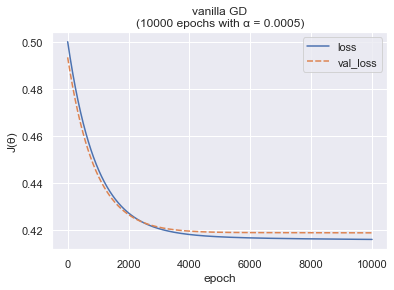

In [261]:
plot_GD_run(*vanilla_run)

#### Mini Batch Gradient Descent

In [262]:
mini_batch_run = run_GD(learning_rate=0.0005, n_epochs=1000, GD_flavor="mini batch", batch_size=173) # 195 batches

(1000 / 1000) training: 0.4136 | validation: 0.4173

Best validation loss: 0.417261 (at epoch 998)


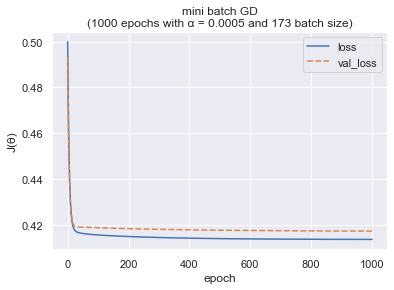

In [263]:
plot_GD_run(*mini_batch_run)

#### Stochastic Gradient Descent

In [264]:
stochastic_run = run_GD(learning_rate=0.0005, n_epochs=100, GD_flavor="stochastic")

(100 / 100) training: 0.4139 | validation: 0.4175

Best validation loss: 0.416476 (at epoch 76)


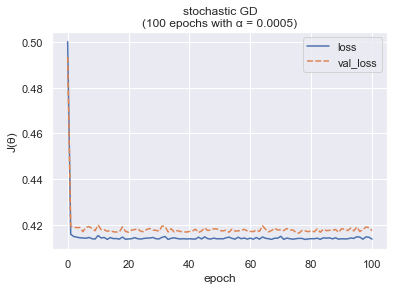

In [265]:
plot_GD_run(*stochastic_run)

### 6.4.3 Verify the $R^2$ score

In [266]:
def r2_score(y_true, y_pred):
    y_true_mean = y_true.mean()
    # residual sum of squares
    u = ((y_true - y_pred) ** 2).sum()
    # total sum of squares
    v = ((y_true - y_true_mean) ** 2).sum()
    return (1 - u/v) # coefficient of determination R^2 of the prediction

In [267]:
def print_r2_score(GD_run, X, y):
    best_params, plot_dict = GD_run
    y_pred = X.dot(best_params) # h(theta)
    r2 = r2_score(y, y_pred)
    print(f"{plot_dict['flavor']} R^2 score: {r2}")

In [268]:
# R^2 score on the validation set
print_r2_score(vanilla_run, val_X, val_y)
print_r2_score(mini_batch_run, val_X, val_y)
print_r2_score(stochastic_run, val_X, val_y)

vanilla R^2 score: 0.15006417777615322
mini batch R^2 score: 0.15353121821055937
stochastic R^2 score: 0.15512339581418855


### 6.4.2 Higher learning rates

#### Vanilla Gradient Descent

(202 / 10000) training: 0.4136 | validation: 0.4171

(10000 / 10000) training: 0.4136 | validation: 0.4171

Best validation loss: 0.417098 (at epoch 431)


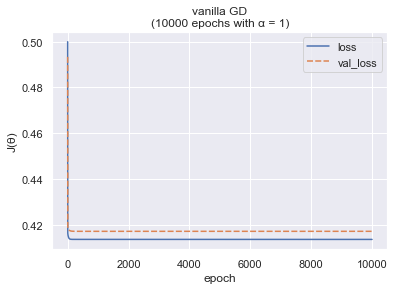

In [269]:
GD_run = run_GD(learning_rate=1, n_epochs=10000, GD_flavor="vanilla")
plot_GD_run(*GD_run)

#### Mini Batch Gradient Descent

(1000 / 1000) training: 0.4175 | validation: 0.4224

Best validation loss: 0.416893 (at epoch 324)


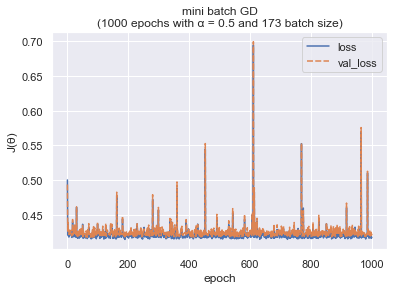

In [270]:
# Unstable learning rate
GD_run = run_GD(learning_rate=0.5, n_epochs=1000, GD_flavor="mini batch", batch_size=173)
plot_GD_run(*GD_run)

(1000 / 1000) training: 0.4140 | validation: 0.4178

Best validation loss: 0.416300 (at epoch 321)


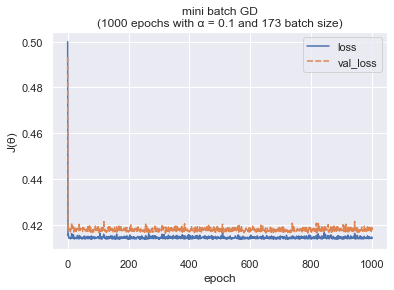

In [271]:
# Usable learning rate
GD_run = run_GD(learning_rate=0.1, n_epochs=1000, GD_flavor="mini batch", batch_size=173)
plot_GD_run(*GD_run)

#### Stochastic Gradient Descent

(50 / 50) training: 7935112926815740631587760373760.0000 | validation: 6894237338837697520487379238912.00000000

Best validation loss: 0.466267 (at epoch 4)


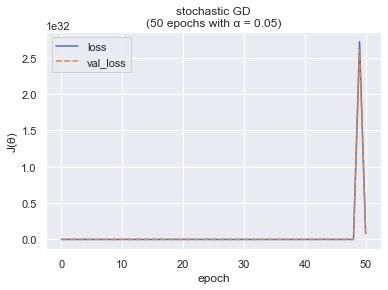

In [273]:
# Exploding learning rate
GD_run = run_GD(learning_rate=0.05, n_epochs=50, GD_flavor="stochastic")
plot_GD_run(*GD_run)

(100 / 100) training: 0.4406 | validation: 0.4441

Best validation loss: 0.418583 (at epoch 56)


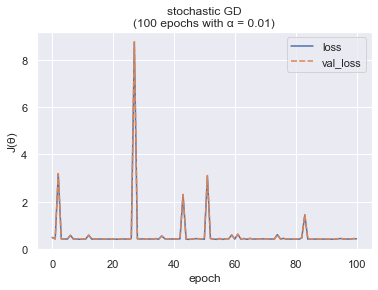

In [274]:
# Too high of a learning rate
GD_run = run_GD(learning_rate=0.01, n_epochs=100, GD_flavor="stochastic")
plot_GD_run(*GD_run)

(100 / 100) training: 0.4183 | validation: 0.4242

Best validation loss: 0.418234 (at epoch 70)


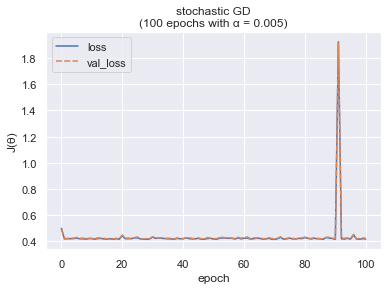

In [275]:
# Unstable learning rate
GD_run = run_GD(learning_rate=0.005, n_epochs=100, GD_flavor="stochastic")
plot_GD_run(*GD_run)

(100 / 100) training: 0.4149 | validation: 0.4194

Best validation loss: 0.416416 (at epoch 46)


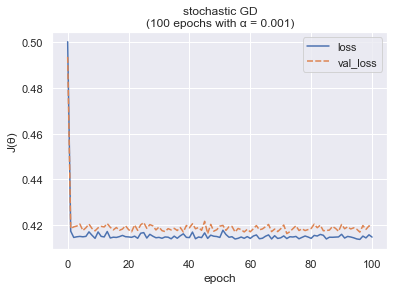

In [276]:
# Usable learning rate
GD_run = run_GD(learning_rate=0.001, n_epochs=100, GD_flavor="stochastic")
plot_GD_run(*GD_run)

## 7. Normal equation: $\theta = (\mathbb{X}^T \mathbb{X})^{-1} \mathbb{X}^T y$

In [277]:
''' Returns a (n+1) x 1 array with the parameter values theta_j that minimize J(theta). '''
def normal_equation(X, y):
    # minimizes the sum of the square differences
    return np.linalg.pinv(X).dot(y) # np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

In [278]:
best_theta = normal_equation(*train_X_y)
print("Best possible parameter values for the training set:")
best_theta

Best possible parameter values for the training set:


array([[-0.02606628],
       [-0.46906469],
       [ 0.11508585],
       [-0.01978614],
       [ 0.04385937],
       [ 0.33097164],
       [-0.15033774],
       [-0.02173649],
       [ 0.14561169],
       [-0.05355202],
       [-0.02114997],
       [ 0.0028129 ],
       [-0.02029161],
       [ 0.17379079],
       [-0.17643669],
       [-0.07198446],
       [-0.06923632],
       [-0.51497449]])

In [279]:
print("Best possible loss for the trainning set:")
loss_function(best_theta, *train_X_y)

Best possible loss for the trainning set:


0.4135600568057268

In [280]:
print("Loss for the validation set:")
loss_function(best_theta, *validation_X_y)

Loss for the validation set:


0.41710319092672454

## 8. scikit-learn's SGDRegressor

In [281]:
from sklearn import linear_model

# ref.: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [282]:
X, y = train_X_y
y = y.reshape(-1) # (n_samples, 1) -> (n_samples, )

val_X, val_y = validation_X_y
val_y = val_y.reshape(-1) # (n_samples, 1) -> (n_samples, )

In [283]:
# we set the parameters to mimic our implementation as best as we can
classifier = linear_model.SGDRegressor(
    loss="squared_loss", 
    penalty="none",           # regularization term
    max_iter=1000, 
    tol=None,                 # stopping criterion (if not None, stops when loss > best_loss - tol for n_iter_no_change epochs)
    learning_rate="constant", # uses eta0
    eta0=0.0005, 
    early_stopping=False)

In [284]:
classifier.fit(X, y) # fits the linear model with the training set

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='none', power_t=0.25,
             random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
             verbose=0, warm_start=False)

In [285]:
classifier.coef_ # weights assigned to the features

array([-0.00361741, -0.46904665,  0.09307687, -0.00769557,  0.05933782,
        0.33673537, -0.15521189, -0.03206136,  0.15940639, -0.06298984,
       -0.0227074 ,  0.00695513, -0.01957602,  0.17648992, -0.17595458,
       -0.06830568, -0.070029  , -0.44577908])

In [286]:
predicted_val_y = classifier.predict(val_X)
predicted_val_y

array([ 0.48297439,  0.68976354, -0.64392432, ...,  0.58002579,
        0.3166113 , -0.60994422])

In [287]:
n_examples = val_X.shape[0]

# same as J(theta), but using the already predicted y, instead of h(theta)
sklearn_val_loss = 0.5 * (1 / n_examples) * np.sum((predicted_val_y - val_y)**2)

In [288]:
print("sklearn's SGDRegressor loss for the validation set:")
sklearn_val_loss

sklearn's SGDRegressor loss for the validation set:


0.4173421848361291

In [289]:
# R^2 score
print("R^2 score:")
print("- training set:   ", classifier.score(*train_X_y))
print("- validation set: ", classifier.score(*validation_X_y))

R^2 score:
- training set:    0.17107529743409022
- validation set:  0.1533669342537911


## 9. Make the model more complex

### 9.1. Map time related features to sine and cosine values

This way we can encode their cyclical nature: 

$x_{sin} = sin(\dfrac{2 \pi x}{max(x)})$

$x_{cos} = cos(\dfrac{2 \pi x}{max(x)})$

In [290]:
# NOTE: we must pass 'train_stats' since that's what we used for all sets
def unnormalize_time_features(df, stats=train_stats):
    unnormalized_df = df.copy()
    for col in ["hour", "weekday", "weekofyear"]:
        mean = stats[col]["mean"]
        std = stats[col]["std"]
        unnormalized_df[col] = unnormalized_df[col].apply(lambda x: (x * std) + mean)
    return unnormalized_df

In [291]:
def mapped_sine_cosine(df, stats=train_stats):
    mapped_df = df.copy()
    for col in ["hour", "weekday", "weekofyear"]:
        max_x = stats[col]["max"]
        mapped_df.insert(0, f"{col}_sin", mapped_df[col].apply(lambda x: np.sin(2 * np.pi * x / max_x)))
        mapped_df.insert(0, f"{col}_cos", mapped_df[col].apply(lambda x: np.cos(2 * np.pi * x / max_x)))
    return mapped_df.drop(columns=["hour", "weekday", "weekofyear"])

In [292]:
mapped_time_features = ["weekofyear_cos", "weekofyear_sin", "weekday_cos", "weekday_sin", "hour_cos", "hour_sin"]

In [293]:
train_data_v2 = mapped_sine_cosine(unnormalize_time_features(train_data))
validation_data_v2 = mapped_sine_cosine(unnormalize_time_features(validation_data))

test_data_v2 = mapped_sine_cosine(unnormalize_time_features(test_data))

### 9.2. Run the new model

In [294]:
if train_data_v2.columns[-1] != 'traffic_volume':
    print("'traffic_volume' should be the last column on the training set!")
if validation_data_v2.columns[-1] != 'traffic_volume':
    print("'traffic_volume' should be the last column on the validation set!")
if test_data_v2.columns[-1] != 'traffic_volume':
    print("'traffic_volume' should be the last column on the test set!")

In [295]:
train_v2_X_y = split_X_y(train_data_v2)
validation_v2_X_y = split_X_y(validation_data_v2)

In [296]:
X_v2, y_v2 = train_v2_X_y
n_examples_v2, n_features_v2 = X_v2.shape # m x (n+1)
print("Training set:")
print(f"n_features_v2: {n_features_v2}")
print(f"n_examples_v2: {n_examples_v2}")

val_X_v2, val_y_v2 = validation_v2_X_y
val_n_examples_v2, val_n_features_v2 = val_X_v2.shape # m x (n+1)
print("\nValidation set:")
print(f"val_n_features_v2: {val_n_features_v2}")
print(f"val_n_examples_v2: {val_n_examples_v2}")

Training set:
n_features_v2: 21
n_examples_v2: 33735

Validation set:
val_n_features_v2: 21
val_n_examples_v2: 7229


### 9.2.1 Learning rate of 0.0005

(179 / 10000) training: 0.4687 | validation: 0.4630

(10000 / 10000) training: 0.1681 | validation: 0.1741

Best validation loss: 0.174052 (at epoch 10000)


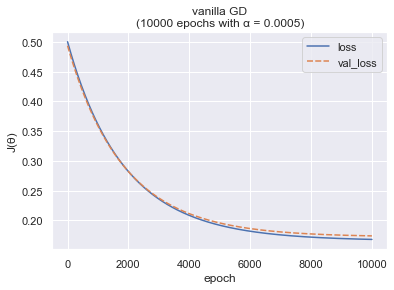

In [297]:
vanilla_run_v2 = run_GD(learning_rate=0.0005, n_epochs=10000, GD_flavor="vanilla", 
                        __train_X_y=train_v2_X_y, __validation_X_y=validation_v2_X_y)
plot_GD_run(*vanilla_run_v2)

(1000 / 1000) training: 0.1646 | validation: 0.1718

Best validation loss: 0.171827 (at epoch 951)


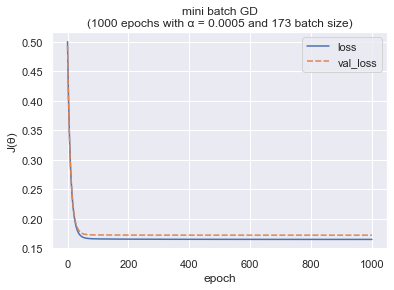

In [298]:
mini_batch_run_v2 = run_GD(learning_rate=0.0005, n_epochs=1000, GD_flavor="mini batch", batch_size=173, 
                           __train_X_y=train_v2_X_y, __validation_X_y=validation_v2_X_y)
plot_GD_run(*mini_batch_run_v2)

(100 / 100) training: 0.1649 | validation: 0.1719

Best validation loss: 0.171668 (at epoch 48)


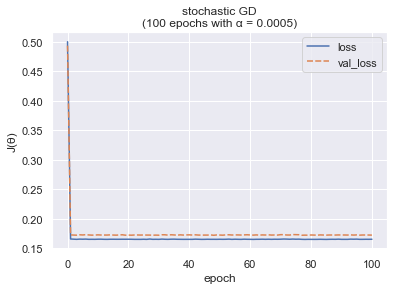

In [299]:
stochastic_run_v2 = run_GD(learning_rate=0.0005, n_epochs=100, GD_flavor="stochastic", 
                           __train_X_y=train_v2_X_y, __validation_X_y=validation_v2_X_y)
plot_GD_run(*stochastic_run_v2)

In [300]:
# check that the target values are the same (we only changed the features used for prediction)
print(all(train_X_y[1] == train_v2_X_y[1]))
print(all(validation_X_y[1] == validation_v2_X_y[1]))

True
True


In [301]:
# R^2 score on the validation set
print_r2_score(vanilla_run_v2, *validation_v2_X_y)
print_r2_score(mini_batch_run_v2, *validation_v2_X_y)
print_r2_score(stochastic_run_v2, *validation_v2_X_y)

vanilla R^2 score: 0.6469134151400782
mini batch R^2 score: 0.6514260844771727
stochastic R^2 score: 0.6517499292247291


### 9.3. Save this more complex model (with sine and cosine encodings)

In [302]:
train_data_v2.to_csv("train_v2_70.csv")
validation_data_v2.to_csv("validation_v2_15.csv")

test_data_v2.to_csv("test_v2_15.csv")

### 9.4. Run SGDRegressor on the new model

In [303]:
X_v2, y_v2 = train_v2_X_y
y_v2 = y_v2.reshape(-1) # (n_samples, 1) -> (n_samples, )

val_X_v2, val_y_v2 = validation_v2_X_y
val_y_v2 = val_y_v2.reshape(-1) # (n_samples, 1) -> (n_samples, )

In [304]:
# we set the parameters to mimic our implementation as best as we can
classifier_v2 = linear_model.SGDRegressor(
    loss="squared_loss", 
    penalty="none",           # regularization term
    max_iter=1000, 
    tol=None,                 # stopping criterion (if not None, stops when loss > best_loss - tol for n_iter_no_change epochs)
    learning_rate="constant", # uses eta0
    eta0=0.0005, 
    early_stopping=False)

In [305]:
classifier_v2.fit(X_v2, y_v2) # fits the linear model with the training set

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='none', power_t=0.25,
             random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
             verbose=0, warm_start=False)

In [306]:
classifier_v2.coef_ # weights assigned to the features

array([ 0.02973411, -0.02321146,  0.00716195, -0.22149047,  0.09818657,
       -1.00212796, -0.48190776, -0.28310004,  0.01355768, -0.00827824,
       -0.01964511,  0.06090153,  0.0472658 ,  0.04138595, -0.01705228,
        0.06583915, -0.04224291,  0.01995609,  0.05166172, -0.02703118,
       -0.27938915])

In [307]:
predicted_val_y_v2 = classifier_v2.predict(val_X_v2)
predicted_val_y_v2

array([ 0.73879323, -0.52854012, -1.17002076, ...,  0.23704128,
       -1.12152727, -1.13343747])

In [308]:
n_examples_v2 = val_X_v2.shape[0]

# same as J(theta), but using the already predicted y, instead of h(theta)
sklearn_val_loss_v2 = 0.5 * (1 / n_examples_v2) * np.sum((predicted_val_y_v2 - val_y_v2)**2)

In [309]:
print("sklearn's SGDRegressor loss for the validation set on the new model:")
sklearn_val_loss_v2

sklearn's SGDRegressor loss for the validation set on the new model:


0.17171336478544388

In [310]:
# R^2 score
print("R^2 score:")
print("- training set:   ", classifier_v2.score(*train_v2_X_y))
print("- validation set: ", classifier_v2.score(*validation_v2_X_y))

R^2 score:
- training set:    0.6704765412872336
- validation set:  0.6516570388996723


### 9.4. Use the Normal Equation

In [311]:
# Best possible parameter values for the training set
best_theta_v2 = normal_equation(*train_v2_X_y)

print("Best possible loss for the trainning set:", loss_function(best_theta_v2, *train_v2_X_y))

print("Loss for the validation set:", loss_function(best_theta_v2, *validation_v2_X_y))

Best possible loss for the trainning set: 0.16457694647371757
Loss for the validation set: 0.17182998690898327


### 9.5 Timeit

In [312]:
from time import time
from IPython.display import clear_output

In [313]:
start = time()
run_GD(learning_rate=0.0005, n_epochs=10000, GD_flavor="vanilla", 
       __train_X_y=train_X_y, __validation_X_y=validation_X_y)
duration = time() - start
clear_output()

In [314]:
print(f"Vanilla GD: {duration:.2f}s")

Vanilla GD: 9.11s


In [315]:
start = time()
run_GD(learning_rate=0.0005, n_epochs=1000, GD_flavor="mini batch", batch_size=173, 
       __train_X_y=train_X_y, __validation_X_y=validation_X_y)
duration = time() - start
clear_output()

In [316]:
print(f"Mini Batch GD: {duration:.2f}s")

Mini Batch GD: 9.83s


In [318]:
start = time()
run_GD(learning_rate=0.0005, n_epochs=100, GD_flavor="stochastic", 
       __train_X_y=train_X_y, __validation_X_y=validation_X_y)
duration = time() - start
clear_output()

In [319]:
print(f"Stochastic GD: {duration:.2f}s")

Stochastic GD: 26.03s


In [320]:
start = time()
normal_equation(*train_X_y)
duration = time() - start

In [321]:
print(f"Normal equation: {duration:.2f}s")

Normal equation: 0.03s
